# GRU-RNN Modell mit den im Vorfeld dieser Thesis aufbereiteten Daten
Hierbei wurde ein GRU-RNN Modell trainiert mit den bereits existierenden Daten von sensalytics. Die Aufteilung in Trainings- und Testdaten ist hierbei im Dokument enthalten, da kein Shuffle enthalten ist und die Zeitreihendaten sortiert sind (Split immer an derselben Stelle). Man hätte diesen Prozess auslagern können, bedingt durch Google Colab war es jedoch einfacher den Prozess in den einzelnen Dokumenten zu behalten.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, GRU
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 98 kB 4.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_NAME = "PQM_691.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/tensorflow/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

## Data-Import:

In [ ]:
raw_dataset = pd.read_csv(CSV_PATH, header=0, 
                              na_values="?", comment='\t',
                              sep=",", skipinitialspace=False)
dataset = raw_dataset.copy()

Anzeigen des Datasets:

In [ ]:
display(dataset.head(5))

,LOCATION_ID,TRACK_DATETIME_LOCAL,TIME_ID,IN_COUNT_LAST_10_MINUTES,OUT_COUNT_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_LAST_10_MINUTES,IN_COUNT_SECOND_LAST_10_MINUTES,OUT_COUNT_SECOND_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,IN_COUNT_THIRD_LAST_10_MINUTES,OUT_COUNT_THIRD_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,IN_COUNT_FOURTH_LAST_10_MINUTES,OUT_COUNT_FOURTH_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,POS_OCCUPANCY_NEXT_10_MINUTES
0,691,2021-09-30 10:22:00.000000,102,28,38,71,78,44,28,73,78,33,27,64,69,32,25,58,63,10
1,691,2021-08-28 08:31:00.000000,83,41,46,68,71,39,37,73,77,42,21,60,73,36,33,50,54,12
2,691,2021-09-25 11:14:00.000000,111,62,65,167,175,85,63,165,173,69,66,157,162,70,57,147,158,19
3,691,2021-09-11 07:55:00.000000,75,27,28,50,57,29,15,46,53,27,14,36,44,15,8,28,32,11
4,691,2021-08-19 17:41:00.000000,174,50,37,106,110,51,48,98,101,49,50,98,103,49,61,100,106,11


## Data-Preparation:

Die Spalten *LOCATION_ID* und *TIME_ID* werden nicht benötigt und werden deshalb aus dem Dataset entfernt.

In [ ]:
if dataset.get('LOCATION_ID') is not None:
    dataset.pop('LOCATION_ID')
if dataset.get('TIME_ID') is not None:
    dataset.pop('TIME_ID')

Danach wird der Index mit der Spalte *TRACK_DATETIME_LOCAL* ersetzt um den Datensatz nach Datum und Zeit sortieren zu können. Das ist bei Zeitreihen-Daten wichtig, damit eine gewisse Tendenz entstehen kann.

In [ ]:
dataset['TRACK_DATETIME_LOCAL'] = pd.to_datetime(dataset['TRACK_DATETIME_LOCAL'], yearfirst=True)
dataset.set_index('TRACK_DATETIME_LOCAL', inplace=True)
dataset.sort_index(inplace=True)

In [ ]:
display(dataset.head(5))

,IN_COUNT_LAST_10_MINUTES,OUT_COUNT_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_LAST_10_MINUTES,IN_COUNT_SECOND_LAST_10_MINUTES,OUT_COUNT_SECOND_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,IN_COUNT_THIRD_LAST_10_MINUTES,OUT_COUNT_THIRD_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,IN_COUNT_FOURTH_LAST_10_MINUTES,OUT_COUNT_FOURTH_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,POS_OCCUPANCY_NEXT_10_MINUTES
TRACK_DATETIME_LOCAL,,,,,,,,,,,,,,,,,
2021-08-12 07:26:00,19,15,15,18,13,7,11,13,14,4,4,10,1,1,0,0,3
2021-08-12 07:28:00,22,17,15,18,14,9,12,15,14,3,5,11,1,2,-1,0,5
2021-08-12 07:29:00,19,19,15,18,16,10,12,17,16,5,6,11,2,3,-1,0,5
2021-08-12 07:40:00,14,16,12,16,16,20,15,18,15,7,13,18,15,4,7,11,2
2021-08-12 07:49:00,17,16,13,17,15,16,12,16,19,19,15,18,16,10,12,17,3


Hier wird der Dataset auf fehlende Werte überprüft im Falle dieser werden die zugehörigen Zeilen entfernt.

In [ ]:
dataset = dataset.dropna()
print(dataset.isna().sum())

IN_COUNT_LAST_10_MINUTES                      0
OUT_COUNT_LAST_10_MINUTES                     0
AVG_STORE_OCCUPANCY_LAST_10_MINUTES           0
MAX_STORE_OCCUPANCY_LAST_10_MINUTES           0
IN_COUNT_SECOND_LAST_10_MINUTES               0
OUT_COUNT_SECOND_LAST_10_MINUTES              0
AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES    0
MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES    0
IN_COUNT_THIRD_LAST_10_MINUTES                0
OUT_COUNT_THIRD_LAST_10_MINUTES               0
AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES     0
MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES     0
IN_COUNT_FOURTH_LAST_10_MINUTES               0
OUT_COUNT_FOURTH_LAST_10_MINUTES              0
AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES    0
MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES    0
POS_OCCUPANCY_NEXT_10_MINUTES                 0
dtype: int64


In [ ]:
dataset.describe()

,IN_COUNT_LAST_10_MINUTES,OUT_COUNT_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_LAST_10_MINUTES,IN_COUNT_SECOND_LAST_10_MINUTES,OUT_COUNT_SECOND_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,IN_COUNT_THIRD_LAST_10_MINUTES,OUT_COUNT_THIRD_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,IN_COUNT_FOURTH_LAST_10_MINUTES,OUT_COUNT_FOURTH_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,POS_OCCUPANCY_NEXT_10_MINUTES
count,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000,38074.000000
mean,48.976808,46.639150,162.494878,169.658638,49.058491,46.301912,160.176761,167.370647,48.916505,45.928508,157.562536,164.734491,48.526396,45.613568,154.890739,161.984294,11.414929
std,17.847955,15.967119,101.042265,102.001419,17.811337,16.229952,101.395433,102.363454,17.982168,16.498689,101.710733,102.727426,18.213001,16.832614,101.990549,103.048054,5.465918
min,2.000000,3.000000,-2.000000,0.000000,0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,-5.000000,-4.000000,1.000000
25%,37.000000,36.000000,84.000000,90.000000,37.000000,36.000000,82.000000,89.000000,37.000000,35.000000,80.000000,87.000000,37.000000,35.000000,79.000000,85.000000,8.000000
50%,47.000000,45.000000,123.000000,130.000000,47.000000,45.000000,121.000000,128.000000,47.000000,45.000000,118.000000,125.000000,46.000000,45.000000,115.000000,122.000000,11.000000
75%,59.000000,55.000000,235.000000,244.000000,59.000000,55.000000,232.000000,240.000000,59.000000,55.000000,230.000000,238.000000,58.000000,55.000000,225.000000,235.000000,14.000000
max,131.000000,120.000000,452.000000,458.000000,131.000000,120.000000,452.000000,458.000000,131.000000,120.000000,452.000000,458.000000,131.000000,120.000000,452.000000,458.000000,48.000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38074 entries, 2021-08-12 07:26:00 to 2021-10-17 20:44:00
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   IN_COUNT_LAST_10_MINUTES                    38074 non-null  int64
 1   OUT_COUNT_LAST_10_MINUTES                   38074 non-null  int64
 2   AVG_STORE_OCCUPANCY_LAST_10_MINUTES         38074 non-null  int64
 3   MAX_STORE_OCCUPANCY_LAST_10_MINUTES         38074 non-null  int64
 4   IN_COUNT_SECOND_LAST_10_MINUTES             38074 non-null  int64
 5   OUT_COUNT_SECOND_LAST_10_MINUTES            38074 non-null  int64
 6   AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES  38074 non-null  int64
 7   MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES  38074 non-null  int64
 8   IN_COUNT_THIRD_LAST_10_MINUTES              38074 non-null  int64
 9   OUT_COUNT_THIRD_LAST_10_MINUTES             38074 non-null  int64
 10 

Hier werden die numerischen Spalten des Datasets ermittelt und dann überprüft ob negative Werte vorhanden sind. Da diese bei der Anzahl wie viele Personen den Laden betreten haben oder wie viele sich im Laden befinden, nicht negativ sein können, werden diese auf den Wert **0** gesetzt.

In [ ]:
numerical_headers = dataset.select_dtypes([np.number]).columns
dataset[numerical_headers] = dataset[numerical_headers].clip(lower=0)

Hier wird die Label-Spalte vom Dataset getrennt.

In [ ]:
y = dataset.pop('POS_OCCUPANCY_NEXT_10_MINUTES')

### Modell mit Sliding Window (Many-To-One trainieren):


Hier wird der Dataset in Trainings- und Testdaten eingeteilt. Dabei ist wichtig das Flag *shuffle=False* zu setzen, damit die Daten nicht gemischt werden. Danach werden die Daten mit Hilfe des **StandardScaler()** oder des **MinMaxScaler()** scaliert. Das verbessert das Training, da sich der Wertebereich der Features nicht so groß unterscheidet.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataset, y, test_size=0.4, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x, train_y)

train_x = input_scaler.transform(train_x)
test_x = input_scaler.transform(test_x)

Die Eingabe für jede RNN-Schicht muss dreidimensional sein. <br>
Die drei Dimensionen dieser Eingabe sind:

- **Samples:** Eine Sequenz ist eine Probe. Eine Batch besteht aus einer oder mehreren Proben.
- **Time Steps:** Ein Zeitschritt ist ein Beobachtungspunkt in der Stichprobe.
- **Features.** Ein Merkmal ist eine Beobachtung pro Zeitschritt.

---

Im *Many-To-One*-Ansatz werden hier die Daten mit dem Sliding-Window verfahren angepasst. Hierbei werden die letzten **n** Timestamps genommen um die nächsten **m** Timestamps vorherzusagen. Mit der Funktion *to_supervised()* werden die Tranings- und Testdaten deshalb angepasst. 

In [ ]:
N_INPUT = 180
M_OUTPUT = 10
FEATURES = dataset.shape[1]
EPOCHS = 100
BATCH_SIZE = 128

In [ ]:
def to_supervised(data, label, n_input, output_ix):
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(label)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		ix_output = ix_end + output_ix
		# ensure we have enough data for this instance
		if ix_output < len(label):
			X.append(data[ix_start:ix_end])
			y.append(label[ix_end:ix_output])
		# move along one time step
		ix_start += 1
	return np.array(X), np.array(y)

In [ ]:
train_x, train_y = to_supervised(train_x, train_y.values, N_INPUT, M_OUTPUT)
test_x, test_y = to_supervised(test_x, test_y.values, N_INPUT, M_OUTPUT)
print("train_x Shape:", train_x.shape)
print("train_y Shape:", train_y.shape)
print("test_x Shape:", test_x.shape)
print("test_y Shape:", test_y.shape)

train_x Shape: (22654, 180, 16)
train_y Shape: (22654, 10)
test_x Shape: (15040, 180, 16)
test_y Shape: (15040, 10)


Implementierung eines Modells ohne die Optimierung der Parameter zum Testen:

In [ ]:
# GRU-RNN Many-To-One Model
model_1 = Sequential()
model_1.add(GRU(64, input_shape=(N_INPUT, FEATURES)))
model_1.add(Dense(64))
model_1.add(Dense(10))

model_1.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mse'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                15744     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 20,554
Trainable params: 20,554
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, verbose=1, callbacks=[early_stop])

Epoch 1/100
177/177 [==============================] - 7s 16ms/step - loss: 43.8413 - mae: 4.9511 - mse: 43.8413 - val_loss: 19.3640 - val_mae: 3.3984 - val_mse: 19.3640
Epoch 2/100
177/177 [==============================] - 2s 12ms/step - loss: 16.8973 - mae: 3.1736 - mse: 16.8973 - val_loss: 12.2926 - val_mae: 2.7612 - val_mse: 12.2926
Epoch 3/100
177/177 [==============================] - 2s 12ms/step - loss: 14.4321 - mae: 2.9454 - mse: 14.4321 - val_loss: 12.4175 - val_mae: 2.7907 - val_mse: 12.4175
Epoch 4/100
177/177 [==============================] - 2s 12ms/step - loss: 13.9114 - mae: 2.8910 - mse: 13.9114 - val_loss: 11.8320 - val_mae: 2.7027 - val_mse: 11.8320
Epoch 5/100
177/177 [==============================] - 2s 12ms/step - loss: 13.5837 - mae: 2.8567 - mse: 13.5837 - val_loss: 11.3549 - val_mae: 2.6387 - val_mse: 11.3549
Epoch 6/100
177/177 [==============================] - 2s 12ms/step - loss: 13.3582 - mae: 2.8342 - mse: 13.3582 - val_loss: 11.5917 - val_mae: 2.6864

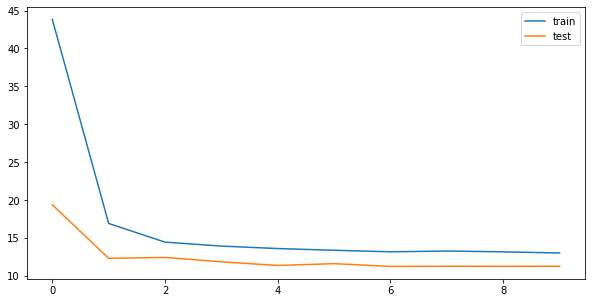

In [ ]:
# plot history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
loss, mae, mse = model_1.evaluate(test_x, test_y, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

470/470 - 2s - loss: 11.2498 - mae: 2.6314 - mse: 11.2498 - 2s/epoch - 4ms/step
Testing set Mean Abs Error:  2.63 MPG


In [ ]:
y_hat = model_1.predict(test_x)
y_hat = y_hat.clip(min=0)

In [ ]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)
  med = median_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  
  return {'MSE': mse, 'RMSE': rmse, 'RMSLE': rmsle, 'MAE':mae, 'MED':med, 'R2':r2}

def evaluate_model(y_true, y_pred):
  df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])

  # Berechnung der Metrics über die einzelnen Vorhersagen
  for i in range(y_true.shape[1]):
    score = pd.Series(calculate_metrics(y_true[:, i], y_pred[:, i]), name='min' + str(i+1) + ':')
    df_scores = df_scores.append(score)
  
  # Berechnugn der Metrics über alle Vorhersagen
  scores_total = pd.Series(calculate_metrics(y_true, y_pred), name='total:')
  df_scores= df_scores.append(scores_total)

  return df_scores

In [ ]:
df_scores = evaluate_model(test_y, y_hat)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,11.201875,3.346920,0.311110,2.619661,2.167266,0.612061
min2:,11.041477,3.322872,0.308935,2.597916,2.137825,0.617660
min3:,11.110289,3.333210,0.311868,2.610143,2.150140,0.615351
min4:,11.108256,3.332905,0.312819,2.610045,2.151448,0.615473
min5:,11.147859,3.338841,0.315094,2.618249,2.156510,0.614155
min6:,11.212288,3.348476,0.317032,2.628539,2.161060,0.611985
min7:,11.306785,3.362556,0.319941,2.643535,2.180532,0.608777
min8:,11.325376,3.365320,0.319450,2.644753,2.180781,0.608207
min9:,11.455333,3.384573,0.322183,2.661720,2.216558,0.603756
min10:,11.588833,3.404237,0.325599,2.679720,2.213616,0.599196


In [ ]:
np.std(test_y)

5.3753738860190685

In [ ]:
def plot_all_predictions(y_pred, y_true):
  # Flatten of the predictions, and get the every 10th
  prediction = y_pred.flatten()[0::10]
  true = y_true.flatten()[0::10]

  plt.figure(figsize=(25,8))
  plt.title("Vergleich der Vorhersagen:")
  plt.plot(true, color='orange', linestyle='-', label='True')
  plt.plot(prediction, color='green', linestyle='--', label='Pred')
  plt.xlabel('Minuten')
  plt.ylabel('Personen im Kassenbereich')
  plt.legend()
  plt.grid()
  plt.show()

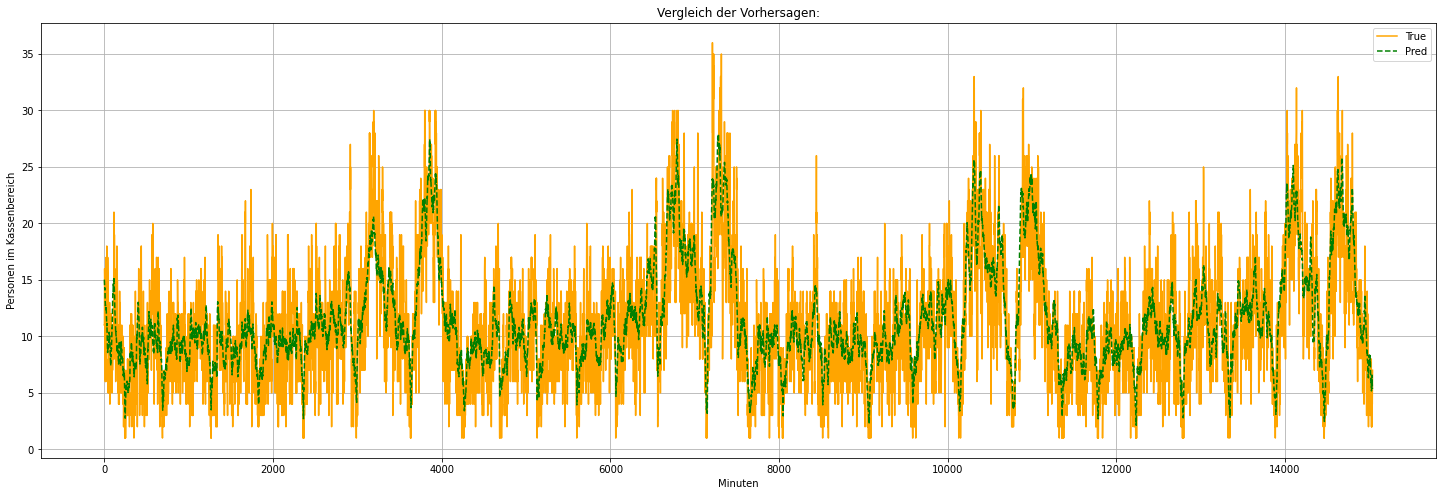

In [ ]:
plot_all_predictions(y_hat, test_y)

### Tuning der Hyperparameter mit Hilfe eines Keras Tuners:

In [ ]:
def build_model(hp):
  # Sequential Model:
  model = Sequential()

  # Input GRU-Layer with Input-Shape:
  model.add(GRU(
    units=hp.Int('input_layer_units',  min_value=8, max_value=128, step=8), 
    input_shape=(N_INPUT, FEATURES), 
    return_sequences=True
  ))

  # Second GRU-Layer
  model.add(GRU(
    units=hp.Int('layer_2_units', min_value=8, max_value=128, step=8),
  ))

  # Dropout-Layer:
  if hp.Boolean('dropout'):
    model.add(
      Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.0, step=0.1)
    ))
    
  # Dense Layer with units:
  model.add(Dense(
    units=hp.Int('units_dense', min_value=32, max_value=512, step=32)
  ))

  # Dense Layer with Output-Shape:
  model.add(Dense(
    units=M_OUTPUT
  ))

  # Configuration of optimizer and learnrate:
  model.compile(
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),  
    metrics=['mae', 'mse'])  

  return model

#### Random Search:

In [ ]:
ran_tuner = kt.RandomSearch(hypermodel=build_model, objective="val_loss", max_trials=30, seed=1111, project_name="ran_project")
ran_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./ran_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./ran_project/oracle.json


INFO:tensorflow:Reloading Tuner from ./ran_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./ran_project/tuner0.json


Search space summary
Default search space size: 6
input_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ran_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/old/tb_logs_ran")])

# Retrieve the best model.s
ran_model = ran_tuner.get_best_models(num_models=1)[0]

Trial 31 Complete [00h 01m 39s]
val_loss: 11.375229835510254

Best val_loss So Far: 10.882926940917969
Total elapsed time: 00h 34m 37s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
ran_parameters = ran_tuner.get_best_hyperparameters(num_trials=1)[0]

ran_parameters.values

{'dropout': True,
 'dropout_rate': 0.0,
 'input_layer_units': 32,
 'layer_2_units': 40,
 'learning_rate': 0.001,
 'units_dense': 288}

In [ ]:
ran_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/ran_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/ran_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/ran_model/assets


#### BayesianOptimazation:

In [ ]:
bay_tuner = kt.BayesianOptimization(build_model, max_trials=30, objective='val_loss', seed=1111, project_name="bay_project")
bay_tuner.search_space_summary()

Search space summary
Default search space size: 5
input_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
bay_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/old/tb_logs_bay")])

# Retrieve the best model.s
bay_model = bay_tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 01m 28s]
val_loss: 11.525197982788086

Best val_loss So Far: 11.249826431274414
Total elapsed time: 00h 51m 20s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
bay_parameters = bay_tuner.get_best_hyperparameters(num_trials=1)[0]

bay_parameters.values

{'dropout': False,
 'dropout_rate': 0.2,
 'input_layer_units': 8,
 'layer_2_units': 64,
 'learning_rate': 0.001,
 'units_dense': 224}

In [ ]:
bay_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/bay_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/bay_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/bay_model/assets


#### Hyperband:

In [ ]:
hyp_tuner = kt.Hyperband(hypermodel=build_model, objective='val_mse', max_epochs=50, seed=1113)
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 5
input_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hyp_tuner.search(train_x, train_y, validation_data=(test_x, test_y), batch_size=128, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/tmp/old/tb_logs_hyp")])

# Retrieve the best model.s
hyp_model = hyp_tuner.get_best_models(num_models=1)[0]

Trial 90 Complete [00h 00m 50s]
val_mse: 11.375997543334961

Best val_mse So Far: 11.237318992614746
Total elapsed time: 00h 47m 59s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
hyp_parameters = hyp_tuner.get_best_hyperparameters(num_trials=1)[0]

hyp_parameters.values

{'dropout': False,
 'dropout_rate': 0.4,
 'input_layer_units': 64,
 'layer_2_units': 120,
 'learning_rate': 0.001,
 'tuner/bracket': 3,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/round': 2,
 'tuner/trial_id': 'fa1d865228aa1f2f449927e8b8cbd16c',
 'units_dense': 192}

In [ ]:
hyp_model.save('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/hyp_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/hyp_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/old/hyp_model/assets
